In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import tensorflow_io as tfio

/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning

# Building a Deep Audio Classifier using original and Mel-Spectograms 
https://www.youtube.com/watch?v=ZLIPkmmDJAc&t=1468s&ab_channel=NicholasRenotte

## Get the data 

In [2]:
# Data from the elephant listening project 
general_path = os.path.join('data', 'Clips')

# To ensure that both classes have same of samples and to increase the number of gunshots, 
# I extracted extra data from: https://data.mendeley.com/datasets/x48cwz364j/3 
background_path = os.path.join('data', 'Sounds_background')
guns_path = os.path.join('data', 'Sounds_gunshots')

gunshot_files = [os.path.join(general_path, 'pnnn*'), os.path.join(general_path, 'ecoguns*'), os.path.join(guns_path, '*\.wav')]

no_gunshot_files = [os.path.join(general_path, 'other*'), os.path.join(background_path, '*\.wav')] 
gunshot = tf.data.Dataset.list_files(gunshot_files) 
no_gunshot = tf.data.Dataset.list_files(no_gunshot_files) 

#to see how many files are in each group: 
#num_elements = tf.data.experimental.cardinality(no_gunshot).numpy()



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## 1. Load data and return wave 

In [3]:
def load_data(file_name): 
    file_contents = tf.io.read_file(file_name) #retuns a string 
    wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # transforms string into actual wav, output = float32
   
    wave = wave - tf.reduce_mean(wave) # remove the mean 
    wave = wave / tf.reduce_max(tf.abs(wave)) #normalize 
    wave = tf.squeeze(wave, axis= -1) #removes axis 
    #wave = tf.cast(wave * 32768, tf.float32) # value is scaled to look like int16, however, type is kept as float32 for compatibility issues # TODO: maybe this is not needed? 
    return wave, sample_rate

## 2. Add labels
1: gunshot 
0: no gunshot

In [4]:
gunshot = tf.data.Dataset.zip((gunshot, tf.data.Dataset.from_tensor_slices(tf.ones(len(gunshot)))))
no_gunshot= tf.data.Dataset.zip((no_gunshot, tf.data.Dataset.from_tensor_slices(tf.zeros(len(gunshot)))))

## 3. Concatenate gunshots and no_gunshots into one data set 

In [5]:
data = gunshot.concatenate(no_gunshot)
data.as_numpy_iterator().next() # see how it looks like 

(b'data/Clips/ecoguns851.wav', 1.0)

## 4. Convert data into Mel-spectogram 
https://www.tensorflow.org/tutorials/audio/simple_audio time frequency compromise <br>
https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe <br> 
https://www.tensorflow.org/io/tutorials/audio mel-spectograms 



In [6]:
def preprocess(file_path, label): 
    # Load data
    wave, sr = load_data(file_path)
    max_lenght = 80000 # = 10* 8000, this means 10 seconds 

    # Padding 
    wave = wave[:max_lenght] #grab first elements up to max(lengths)
    zero_padding = tf.zeros(max_lenght - tf.shape(wave), dtype=tf.float32) # pad with zeros what doesn't meet full length 
    wave = tf.concat([zero_padding, wave],0) 

    # Create spectogram 
    # 1. Fast fourier transform 
    spectrogram = tf.signal.stft(wave, frame_length=256, frame_step=128)  # Paper: 'Automated detection of gunshots in tropical forests using CNN' 
    # frame_length =  window length in samples
    # frame_step = number of samples to step
    # 'Time frequency compromise' 
    # if window size is small: you get good time resolution in exchange of poor frequency resolution 

    # 2. Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)
    # 3. Convert to mel-spectogram 
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=4000) # TODO: play with this numbers 

    # 4. Tranform it into appropiate format for deep learning model by adding the channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)

    return mel_spectrogram, label


Testing

In [ ]:
file_name = 'data/Clips/ecoguns105.wav' # seems good  
mel, label = preprocess(file_name, 1)
mel.shape # TensorShape([624, 128, 1])

In [ ]:
#file_name = 'data/Clips/ecoguns1.wav' # bad: pixeled -- and quite a few are the same (1-4)
file_name = 'data/Clips/ecoguns105.wav' # seems good  
file_name = 'data/Clips/pnnn4.wav'
file_name = 'data/Clips/other1.wav'
file_name = 'data/Clips_denoised/spectral_gating/ecoguns0.wav'


#file_name = 'data/Clips_denoised/gunshots/spectral_gating/ecoguns0.wav'
waveform, sr = load_data(file_name)
spectrogram, label = preprocess(file_name, '1')

# The reason the plot only shows frequencies up to 140 Hz is because the spectrogram is plotted using a log scale,
#  which compresses higher frequencies. The pcolormesh function is plotting the spectrogram as a 2D heatmap where 
# the x-axis represents time and the y-axis represents frequency, and the color represents the magnitude of the spectrogram 
# at each time-frequency point.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  t = np.arange(len(waveform)) / 8000
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# tensor flow website 
#fig, ax = plt.subplots()
#plot_spectrogram(spectrogram, ax)
fig, axes = plt.subplots(2, figsize=(12, 8))
t = np.arange(len(waveform)) / 8000
axes[0].plot(t, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])

axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


#online 
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

#youtube video 
#plt.figure(figsize=(30,20))
#plt.imshow(tf.transpose(spectrogram)[0])
#plt.show()


## 5. Shuffle the data such that not all gunshots are followed by gunshots, and similarly with no gunshots. 

In [7]:
data = data.map(preprocess) # calling preprocess method which generates spectograms
data = data.cache()
data = data.shuffle(buffer_size=1000) # mixing training samples 1000 at the time 

## 6. Extract samples and labels

In [8]:
iterator = data.as_numpy_iterator()
x = []
y = []
while True:
    try: 
        x_temp, y_temp = iterator.next()
        x.append(x_temp)
        y.append(y_temp)
    except Exception:
        break 

2023-04-26 10:34:35.926491: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## 7. Build model and evaluate it's performance by doing k-Fold Cross Validation
https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ <br>
https://repository.tudelft.nl/islandora/object/uuid%3A6f4f3def-f8e0-4820-8b4f-75b0254dadcd <br>
https://stackoverflow.com/questions/50997928/typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-index-with-1d 

In [9]:
epoch = 20 # 40 
batch = 8
splits = 10
input = (624, 128, 1) 
# input matches with the size of data, which can be obtained as: samples,labels = data.as_numpy_iterator().next()

kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=123)
acc_scores = []
histories = []
confusion_matrices = []
for train, test in kfold.split(x, y):
    # 1. Create model
    model = Sequential()

    model.add(Conv2D(filters= 32, kernel_size = (3,3), activation='relu', input_shape=input)) #matching samples.shape
    model.add(MaxPool2D(pool_size= (2,2)))

    model.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu'))
    model.add(MaxPool2D(pool_size= (2,2)))


    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # 2. Compile model
    model.compile(loss="BinaryCrossentropy", optimizer=keras.optimizers.legacy.SGD(learning_rate=0.01), metrics = ['accuracy', 'Recall', 'Precision']) 
    
    # 3. Fit the model
    x_train = np.array(x)[train.astype(int)]
    y_train = np.array(y)[train.astype(int)]
    x_test = np.array(x)[test.astype(int)]
    y_test = np.array(y)[test.astype(int)]
    
    hist = model.fit(x_train, y_train, epochs=epoch, batch_size=batch, verbose=0, validation_data = (x_test, y_test))
    
    # Save information about model 
    histories.append(hist)
    
    # Display accuracy of validation set 
    print("%s: %.2f%%" % (model.metrics_names[1], hist.history['val_accuracy'][epoch-1] *100))
    acc_scores.append(hist.history['val_accuracy'][epoch-1] * 100)

    # Store confusion matrix 
    y_pred = model.predict(x_test)
    y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
    confusion_matrices.append(confusion_mtx)
 
print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))

accuracy: 91.27%
12/12 [==============================] - 1s 45ms/step
accuracy: 92.68%
12/12 [==============================] - 1s 59ms/step
accuracy: 93.50%
12/12 [==============================] - 1s 67ms/step
accuracy: 91.81%
12/12 [==============================] - 1s 76ms/step
accuracy: 90.11%
12/12 [==============================] - 1s 86ms/step
accuracy: 93.79%
12/12 [==============================] - 1s 82ms/step
accuracy: 92.66%
12/12 [==============================] - 1s 84ms/step
accuracy: 93.22%
12/12 [==============================] - 1s 43ms/step
accuracy: 92.66%
12/12 [==============================] - 1s 74ms/step
accuracy: 92.09%
12/12 [==============================] - 1s 41ms/step
92.38% (+/- 1.05%)


Information about model 

In [10]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 622, 126, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 311, 63, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 309, 61, 16)       4624      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 154, 30, 16)      0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 73920)             0         
                                                                 
 dense_27 (Dense)            (None, 500)              

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))

## 8. Confusion Matrix
https://www.tensorflow.org/tutorials/audio/simple_audio

In [11]:
mean_matrix = np.mean(confusion_matrices, axis=0)

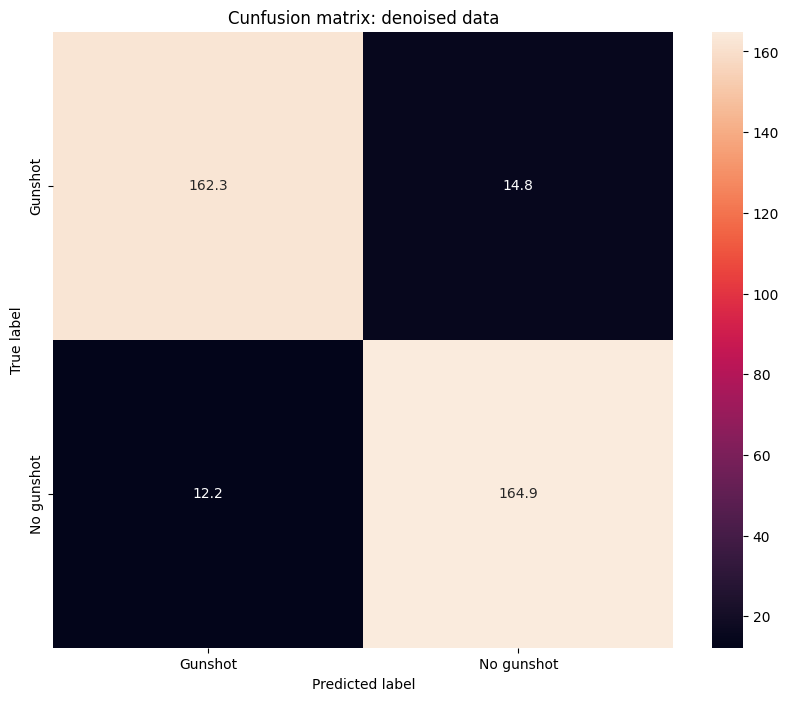

In [12]:
label_names = ['Gunshot' ,'No gunshot']
plt.figure(figsize=(10, 8))
sns.heatmap(mean_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Cunfusion matrix: denoised data')
plt.savefig('confusion_matrix_denoised.png')
plt.show()


## 9. Display and save graphs for other metrics 

Obtain the mean of all different k-folds 

In [13]:
list_loss = []
list_val_loss = []

list_precision = []
list_val_precision = []

list_recall = []
list_val_recall = []

list_accuracy = []
list_val_accuracy = []

for i in range(epoch):
    temp_loss = [ hist.history['loss'][i] for hist in histories ]
    list_loss.append(np.mean(temp_loss))
    temp_val_loss = [ hist.history['val_loss'][i] for hist in histories ]
    list_val_loss.append(np.mean(temp_val_loss))

    temp_precision = [ hist.history['precision'][i] for hist in histories ]
    list_precision.append(np.mean(temp_precision))
    temp_val_precision = [ hist.history['val_precision'][i] for hist in histories ]
    list_val_precision.append(np.mean(temp_val_precision))

    temp_recall = [ hist.history['recall'][i] for hist in histories ]
    list_recall.append(np.mean(temp_recall))
    temp_val_recall = [ hist.history['val_recall'][i] for hist in histories ]
    list_val_recall.append(np.mean(temp_val_recall))

    temp_accuracy = [ hist.history['accuracy'][i] for hist in histories ]
    list_accuracy.append(np.mean(temp_accuracy))
    temp_val_accuracy = [ hist.history['val_accuracy'][i] for hist in histories ]
    list_val_accuracy.append(np.mean(temp_val_accuracy))


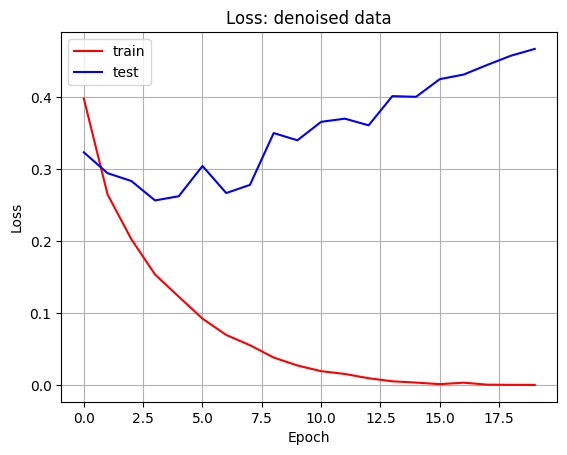

In [14]:
plt.title('Loss: denoised data')
plt.plot(list_loss, 'r')
plt.plot(list_val_loss, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.grid()
plt.savefig('loss_denoised_data.png')
plt.show()

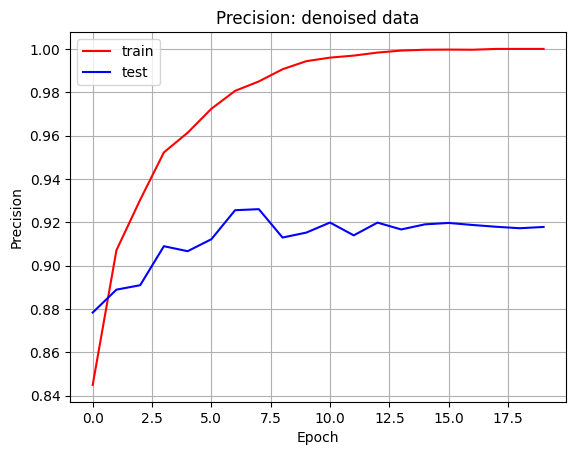

In [15]:
plt.title('Precision: denoised data')
plt.plot(list_precision, 'r')
plt.plot(list_val_precision, 'b')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'test'])
plt.grid()
plt.savefig('precision_denoised_data.png')
plt.show()

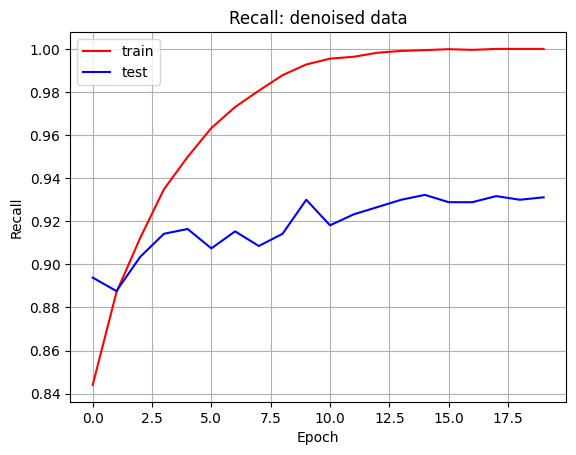

In [16]:
plt.title('Recall: denoised data')
plt.plot(list_recall, 'r')
plt.plot(list_val_recall, 'b')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'test'])
plt.grid()
plt.savefig('recall_denoised_data.png')
plt.show()

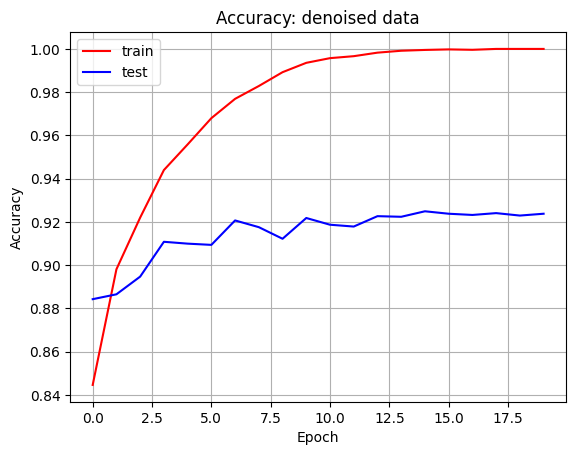

In [17]:
plt.title('Accuracy: denoised data')
plt.plot(list_accuracy, 'r')
plt.plot(list_val_accuracy, 'b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
plt.savefig('accuracy_denoised_data.png')
plt.show()

## 8. Make a single prediction 

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat


In [ ]:
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]
yhat

In [ ]:
y_test